In [60]:
#%pip install numpy pandas matplotlib seaborn scikit-learn umap-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import umap
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import MDS, SpectralEmbedding
from sklearn.cluster import SpectralCoclustering, KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_selection import f_classif
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
from joblib import Parallel, delayed
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigvals

In [2]:
# Load file to df
df = pd.read_csv('authors.csv')

# Check if it is successfully loaded
df.head()

,Unnamed: 0,a,all,also,an,and,any,are,as,at,...,were,what,when,which,who,will,with,would,your,BookID
0,Austen,46,12,0,3,66,9,4,16,13,...,11,7,5,6,8,4,9,1,0,1
1,Austen,35,10,0,7,44,4,3,18,16,...,13,5,7,7,3,5,14,8,0,1
2,Austen,46,2,0,3,40,1,13,11,9,...,6,10,4,6,4,5,15,3,9,1
3,Austen,40,7,0,4,64,3,3,20,13,...,10,3,6,10,5,3,22,4,3,1
4,Austen,29,5,0,6,52,5,14,17,6,...,5,8,4,13,2,4,21,10,0,1


In [3]:
# Rename Author column to Author
df = df.rename(columns={'Unnamed: 0':'Author Name'})

# Store the author label for validation
author_labels = df['Author Name']

# Remove Book_ID column for visualization and Author column for analysis
df_analysis = df.drop(columns=['BookID', 'Author Name'])

In [4]:
# Dimension reduction methods to use (each applied to both observations and features)
dr_methods = {
    'PCA': PCA(n_components=2),
    'MDS': MDS(n_components=2, random_state=42),
    'Spectral Embedding': SpectralEmbedding(n_components=2, random_state=42),
    'UMAP': umap.UMAP(n_components=2, random_state=42),
    'NMF': NMF(n_components=2, init='random', random_state=42)
}

# Create a mapping for authors to colors
unique_authors = np.unique(author_labels)
color_map = {author: idx for idx, author in enumerate(unique_authors)}
colors = author_labels.map(color_map)

In [ ]:
# (a) Visualization for observations (book chapters)
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(dr_methods.items()):
    try:
        # Convert df_features to numpy array and reduce dimensions
        reduced = model.fit_transform(df_analysis.to_numpy())
        plt.subplot(2, 3, i + 1)
        plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, cmap='tab10', alpha=0.7)
        plt.title(f'{name} (Observations)')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
    except Exception as e:
        print(f'{name} failed: {e}')
plt.tight_layout()
plt.show()

In [ ]:
# (b) Visualization for features (words)
# Transpose the observation matrix to treat words as observations.
df_words = df_analysis.T
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(dr_methods.items()):
    try:
        reduced_feats = model.fit_transform(df_words.to_numpy())
        plt.subplot(2, 3, i + 1)
        plt.scatter(reduced_feats[:, 0], reduced_feats[:, 1], c='green', alpha=0.7)
        # Annotate each point with its corresponding word (feature name)
        for j, word in enumerate(df_words.index):
            plt.annotate(word, (reduced_feats[j, 0], reduced_feats[j, 1]), fontsize=8, alpha=0.75)
        plt.title(f'{name} (Features)')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
    except Exception as e:
        print(f'{name} failed for features: {e}')
plt.tight_layout()
plt.show()

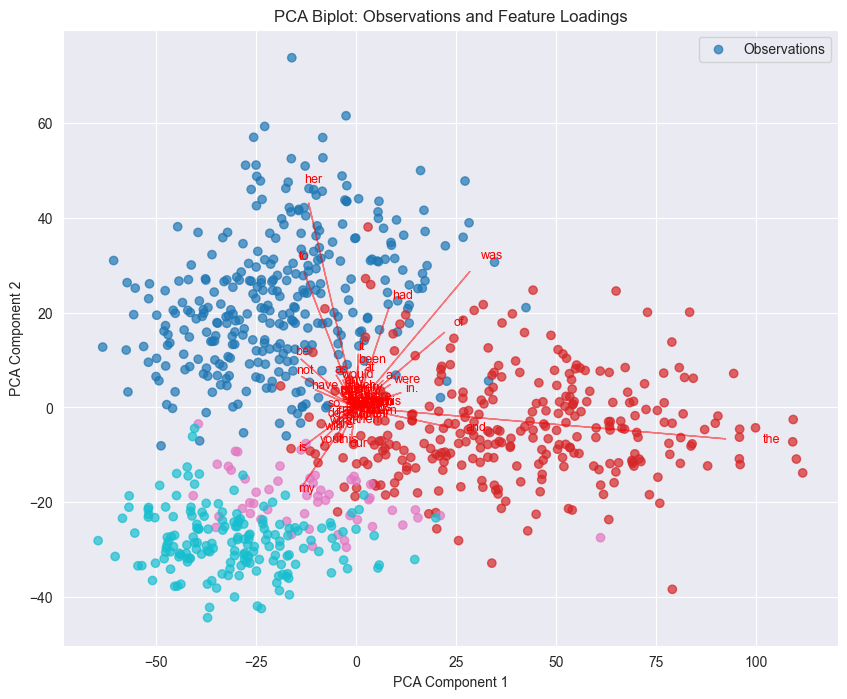

In [7]:
# (c) Combined visualization: PCA biplot for observations and feature loadings
# Apply PCA to observations
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_analysis.to_numpy())
loadings = pca.components_.T

plt.figure(figsize=(10, 8))

# Plot observations with color based on author labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', alpha=0.7, label='Observations')

# Scale loadings to fit within the observation plot region
scaling_factor_x = np.max(np.abs(X_pca[:, 0]))
scaling_factor_y = np.max(np.abs(X_pca[:, 1]))
for i, word in enumerate(df_analysis.columns):
    plt.arrow(0, 0, loadings[i, 0]*scaling_factor_x, loadings[i, 1]*scaling_factor_y,
              color='red', alpha=0.5, head_width=0.05)
    plt.text(loadings[i, 0]*scaling_factor_x*1.1,
             loadings[i, 1]*scaling_factor_y*1.1,
             word, color='red', fontsize=9)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Biplot: Observations and Feature Loadings')
plt.legend(loc='best')
plt.show()

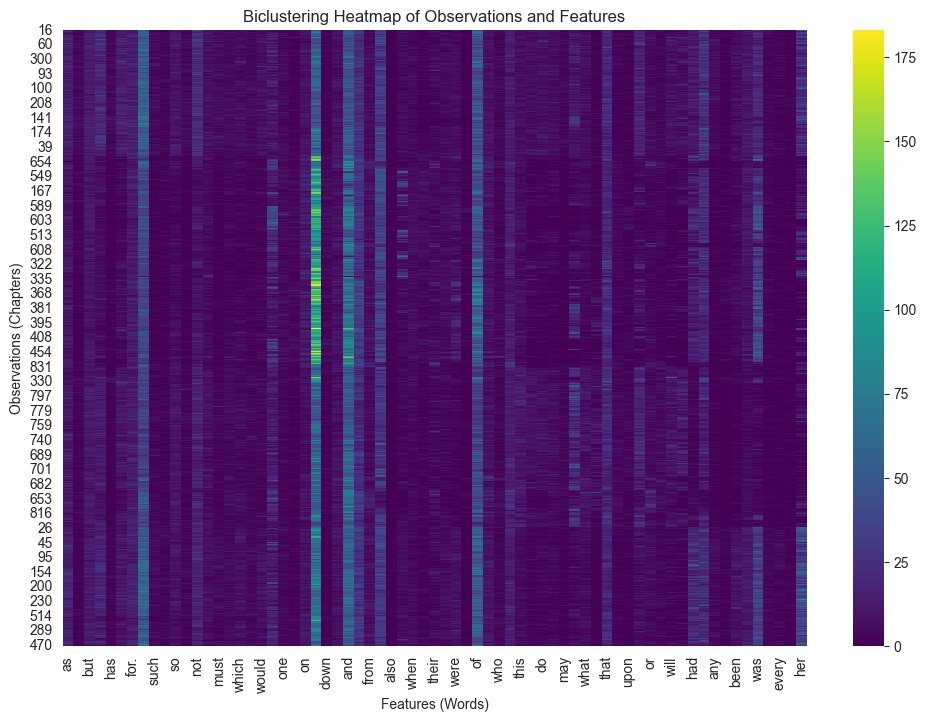

In [8]:
# Additional combined visualization: Biclustering heatmap
# Perform biclustering using SpectralCoclustering
bicluster = SpectralCoclustering(n_clusters=len(unique_authors), random_state=42)
bicluster.fit(df_analysis)

# Rearrange the data based on bicluster assignments
df_reordered = df_analysis.iloc[np.argsort(bicluster.row_labels_)]
df_reordered = df_reordered.iloc[:, np.argsort(bicluster.column_labels_)]

plt.figure(figsize=(12, 8))
sns.heatmap(df_reordered, cmap='viridis')
plt.title('Biclustering Heatmap of Observations and Features')
plt.xlabel('Features (Words)')
plt.ylabel('Observations (Chapters)')
plt.show()

In [ ]:
# Combined visualization using correlation as pseudo-loadings for each DR method
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(dr_methods.items()):
    try:
        # Apply DR model on observations (df_analysis)
        embedding = model.fit_transform(df_analysis.to_numpy())
        ax = plt.subplot(3, 2, i + 1)
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='tab10', alpha=0.7)
        ax.set_title(f'{name} Combined Visualization')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        # Compute pseudo-loadings via correlation for each feature
        loadings = []
        for col in df_analysis.columns:
            # Compute correlation between feature and each component using np.corrcoef
            corr_x = np.corrcoef(embedding[:, 0], df_analysis[col])[0, 1]
            corr_y = np.corrcoef(embedding[:, 1], df_analysis[col])[0, 1]
            loadings.append((corr_x, corr_y))
        loadings = np.array(loadings)
        # Determine scaling factor for arrows based on the spread of observations
        scaling_factor = 0.8 * max(np.max(np.abs(embedding[:, 0])), np.max(np.abs(embedding[:, 1])))
        # Draw arrows for the loadings
        for j, word in enumerate(df_analysis.columns):
            ax.arrow(0, 0, loadings[j, 0] * scaling_factor, loadings[j, 1] * scaling_factor,
                     color='red', alpha=0.6, head_width=0.05)
            ax.text(loadings[j, 0] * scaling_factor * 1.1,
                    loadings[j, 1] * scaling_factor * 1.1,
                    word, color='red', fontsize=8)
    except Exception as e:
        print(f'{name} combined visualization failed: {e}')

plt.tight_layout()
plt.show()

In [11]:
# Function to compute clustering accuracy via Hungarian method
def clustering_accuracy(true_labels, pred_labels):
    # Create contingency matrix (confusion matrix)
    cm = confusion_matrix(true_labels, pred_labels)
    # Solve the linear assignment problem
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / np.sum(cm)

X = df_analysis.to_numpy()
true_numeric = author_labels.map(color_map).to_numpy()

# Dictionary to hold clustering results and accuracy values
cluster_results = {}

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
pred_kmeans = kmeans.fit_predict(X)
acc_kmeans = clustering_accuracy(true_numeric, pred_kmeans)
cluster_results['KMeans'] = (pred_kmeans, acc_kmeans)

# Agglomerative Clustering with Ward linkage
agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
pred_agg_ward = agg_ward.fit_predict(X)
acc_agg_ward = clustering_accuracy(true_numeric, pred_agg_ward)
cluster_results['Agglomerative_Ward'] = (pred_agg_ward, acc_agg_ward)

# Agglomerative Clustering with Complete linkage
agg_complete = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='complete')
pred_agg_complete = agg_complete.fit_predict(X)
acc_agg_complete = clustering_accuracy(true_numeric, pred_agg_complete)
cluster_results['Agglomerative_Complete'] = (pred_agg_complete, acc_agg_complete)

# Agglomerative Clustering with Average linkage
agg_average = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='average')
pred_agg_average = agg_average.fit_predict(X)
acc_agg_average = clustering_accuracy(true_numeric, pred_agg_average)
cluster_results['Agglomerative_Average'] = (pred_agg_average, acc_agg_average)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
pred_gmm = gmm.fit_predict(X)
acc_gmm = clustering_accuracy(true_numeric, pred_gmm)
cluster_results['GaussianMixture'] = (pred_gmm, acc_gmm)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
pred_spectral = spectral.fit_predict(X)
acc_spectral = clustering_accuracy(true_numeric, pred_spectral)
cluster_results['SpectralClustering'] = (pred_spectral, acc_spectral)

# Print clustering accuracy for each method
for method, (pred, acc) in cluster_results.items():
    print(f"{method} Accuracy: {acc:.3f}")

KMeans Accuracy: 0.916
Agglomerative_Ward Accuracy: 0.780
Agglomerative_Complete Accuracy: 0.644
Agglomerative_Average Accuracy: 0.562
GaussianMixture Accuracy: 0.952
SpectralClustering Accuracy: 0.988


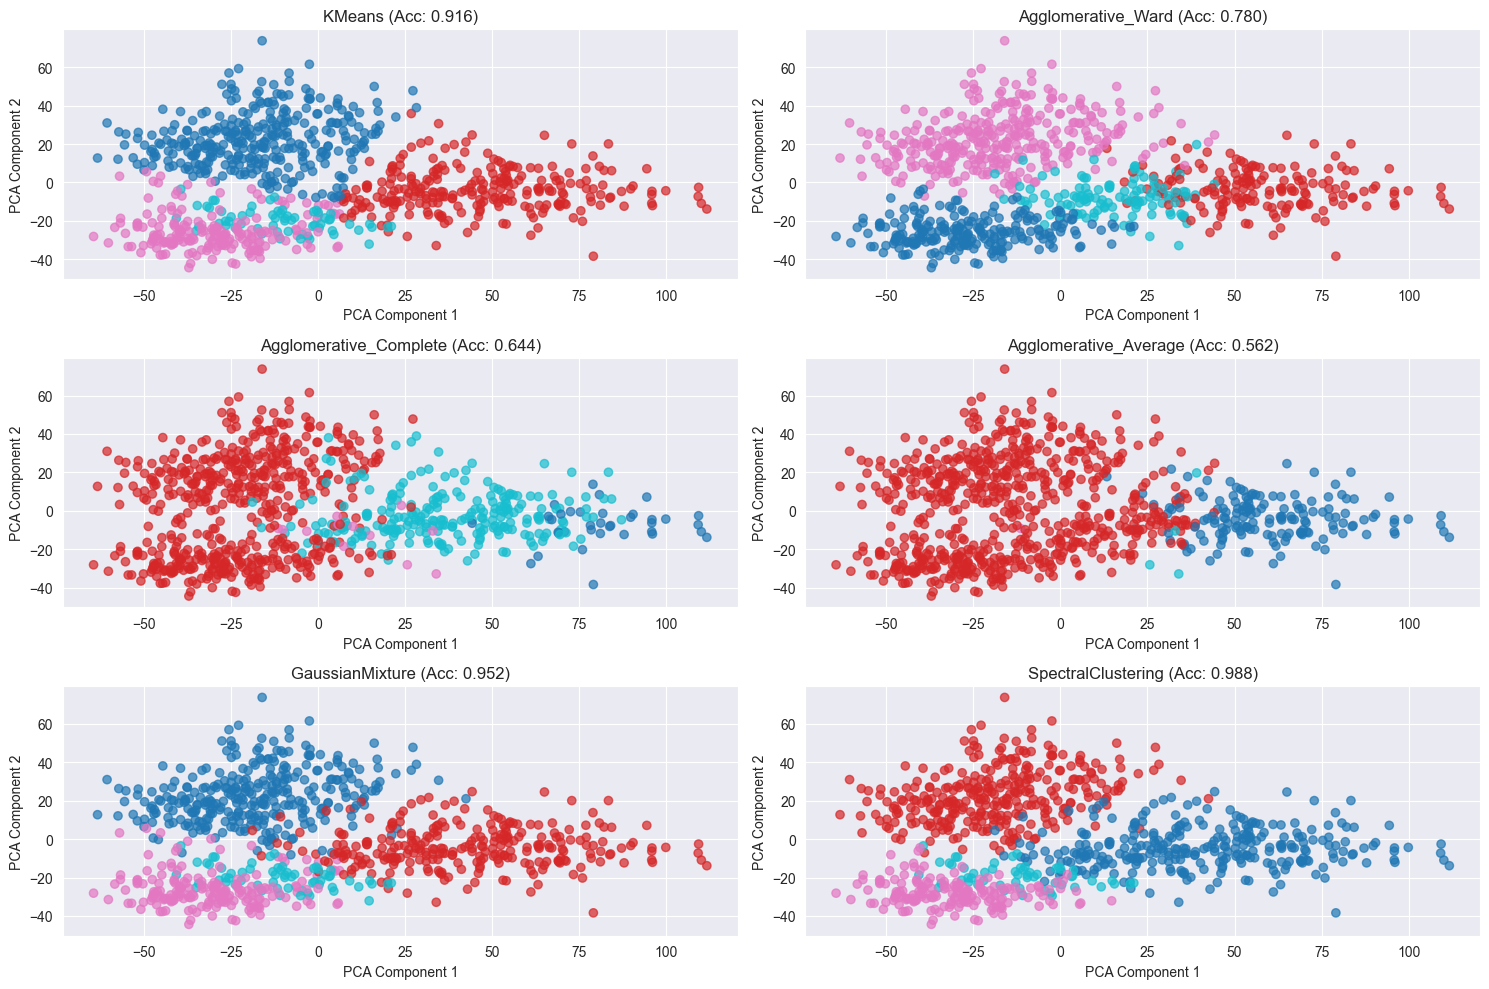

In [12]:
# Visualization: reduce to 2 dimensions using PCA for plotting
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(15, 10))
n_methods = len(cluster_results)
for i, (method, (pred, acc)) in enumerate(cluster_results.items()):
    ax = plt.subplot(3, 2, i+1)
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pred, cmap='tab10', alpha=0.7)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_title(f"{method} (Acc: {acc:.3f})")
plt.tight_layout()
plt.show()

the     485.374047
was     422.996970
be      370.069681
her     302.534143
to      297.838872
or      233.048749
not     227.030878
any     224.615119
had     185.025582
been    180.689632
this    169.660330
have    165.416743
must    155.917015
it      150.385000
my      143.399799
dtype: float64


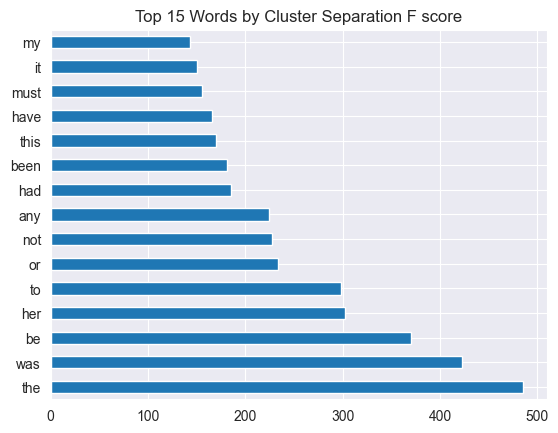

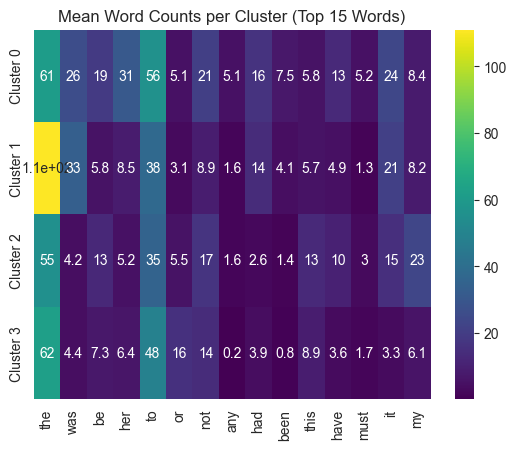

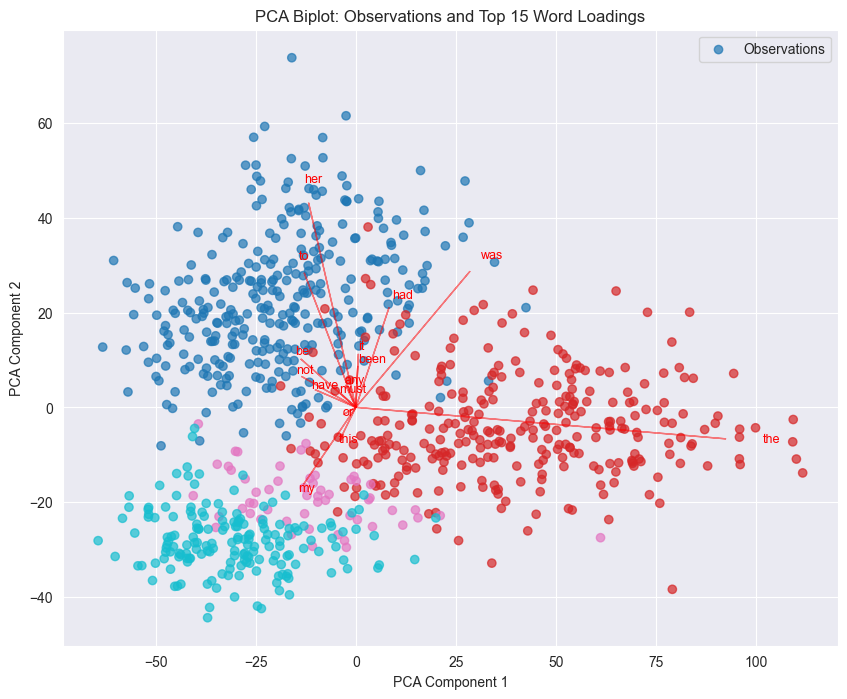

In [20]:
# First, conduct unsupervised grouping of chapters using spectral (since it performed the best)
clusterer = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=0)
labels = clusterer.fit_predict(X)

# Rank words by how well they separate those clusters with F-scores
F_scores, p_vals = f_classif(X, labels)
word_scores = pd.Series(F_scores, index=df_analysis.columns)
top_words = word_scores.nlargest(15)
print(top_words)

# visualize by bar plot of F-scores
top_words.plot(kind='barh', title='Top 15 Words by Cluster Separation F score')
plt.show()

# Cluster‑centroid heatmap for those words
centroids = pd.DataFrame([
    X[labels==k, :].mean(axis=0) for k in range(4)
], columns=df_analysis.columns)
sns.heatmap(centroids[top_words.index],
            yticklabels=[f'Cluster {k}' for k in range(4)],
            cmap='viridis', annot=True)
plt.title('Mean Word Counts per Cluster (Top 15 Words)')

# PCA biplot but only include the top 15 words
# Apply PCA on the analysis data.
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_analysis.to_numpy())
loadings = pca.components_.T

plt.figure(figsize=(10, 8))

# Scatter plot for observations (chapters) colored based on author labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', alpha=0.7, label='Observations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Biplot: Observations and Top 15 Word Loadings')

# Scale factor to help draw the arrows proportional to the spread of observations.
scaling_factor_x = np.max(np.abs(X_pca[:, 0]))
scaling_factor_y = np.max(np.abs(X_pca[:, 1]))

# Draw arrows only for the top 15 words.
for word in top_words.index:
    # Find the index of the word in the df_analysis columns to get its loading
    i = df_analysis.columns.get_loc(word)
    arrow_x = loadings[i, 0] * scaling_factor_x
    arrow_y = loadings[i, 1] * scaling_factor_y
    plt.arrow(0, 0, arrow_x, arrow_y, color='red', alpha=0.5, head_width=0.05)
    plt.text(arrow_x * 1.1, arrow_y * 1.1, word, color='red', fontsize=9)

plt.legend(loc='best')
plt.show()



In [ ]:
# Define clustering constructors
cluster_fns = {
    'kmeans':       lambda k: KMeans(n_clusters=k, random_state=0),
    'gmm':          lambda k: GaussianMixture(n_components=k, random_state=0),
    'spectral':     lambda k: SpectralClustering(n_clusters=k,
                                                affinity='nearest_neighbors',
                                                assign_labels='kmeans',
                                                random_state=0),
    'agg_ward':     lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward')
}

# Stability via bootstrap + Adjusted Rand
def cluster_labels(fn, X):
    """Fit & return flat array of labels for any model that has .fit or .fit_predict."""
    model = fn
    if hasattr(model, 'fit_predict'):
        return model.fit_predict(X)
    else:
        # e.g. GaussianMixture
        model.fit(X)
        return model.predict(X)

def stability_score(cluster_ctor, X, k, B=20, frac=0.8):
    n, m = X.shape
    aris = []
    for _ in range(B):
        i1 = np.random.choice(n, int(frac*n), replace=False)
        i2 = np.random.choice(n, int(frac*n), replace=False)
        labs1 = cluster_labels(cluster_ctor(k),   X[i1])
        labs2 = cluster_labels(cluster_ctor(k),   X[i2])
        # map back to common indices
        common = np.intersect1d(i1, i2)
        mask1 = np.isin(i1, common)
        mask2 = np.isin(i2, common)
        aris.append(adjusted_rand_score(labs1[mask1], labs2[mask2]))
    return np.mean(aris)

# Generalizability via hold‑out + classifier recovery
def generalizability_score(cluster_ctor, X, k, test_frac=0.3):
    n = X.shape[0]
    # split indices
    idx = np.arange(n)
    np.random.shuffle(idx)
    cut = int((1-test_frac)*n)
    train, test = idx[:cut], idx[cut:]
    # get pseudo‑labels on train
    y_train = cluster_labels(cluster_ctor(k), X[train])
    # train simple classifier to predict cluster
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X[train], y_train)
    # predict on hold‑out and compare to clustering of hold‑out
    y_test_pred = clf.predict(X[test])
    y_test_true = cluster_labels(cluster_ctor(k), X[test])
    return adjusted_rand_score(y_test_true, y_test_pred)

# prepare data matrix X (n_chapters × n_words)
X = df.drop(columns=['Author Name','BookID']).values

results = []
Ks = range(2, 7)    # try k = 2,3,4,5,6

for name, ctor in cluster_fns.items():
    stab_scores = []
    gen_scores  = []
    for k in Ks:
        stab = stability_score(ctor, X, k)
        gen  = generalizability_score(ctor, X, k)
        stab_scores.append(stab)
        gen_scores .append(gen)
    results.append(pd.DataFrame({
        'method': name,
        'k':       list(Ks),
        'stability': stab_scores,
        'generalizability': gen_scores
    }))

df_scores = pd.concat(results, ignore_index=True)
print(df_scores)

# melt for plotting
dfm = df_scores.melt(id_vars=['method','k'],
                     value_vars=['stability','generalizability'],
                     var_name='metric',
                     value_name='score')

# lineplot
plt.figure(figsize=(10,5))
sns.lineplot(data=dfm, x='k', y='score', hue='method', style='metric', markers=True)
plt.title('Stability & Generalizability vs. k')
plt.show()

In [65]:
# EM Implementation from Scratch
def fit_gmm_em(X, K, tol=1e-6, max_iter=200):
    N, D = X.shape
    # 1. Initialize: KMeans for means, equal weights, common covariance
    km = KMeans(n_clusters=K, random_state=0).fit(X)
    mus = km.cluster_centers_
    pis = np.bincount(km.labels_, minlength=K) / N
    common_cov = np.cov(X, rowvar=False)
    Sigmas = np.array([common_cov + 1e-6*np.eye(D)]*K)  # small reg

    log_likelihoods = []
    for it in range(max_iter):
        # E-step: responsibilities
        resp = np.zeros((N, K))
        for k in range(K):
            resp[:,k] = pis[k] * multivariate_normal.pdf(X, mean=mus[k], cov=Sigmas[k])
        ll = np.log(resp.sum(axis=1) + 1e-12).sum()
        log_likelihoods.append(ll)
        resp /= resp.sum(axis=1, keepdims=True)

        # M-step updates
        Nk = resp.sum(axis=0)            # shape (K,)
        pis = Nk / N                     # update mixing weights
        mus = (resp.T @ X) / Nk[:,None]  # update means
        for k in range(K):
            Xc = X - mus[k]
            gamma = resp[:,k][:,None]   # shape (N,1)
            Sigmas[k] = (Xc*gamma).T @ Xc / Nk[k] + 1e-6*np.eye(D)

        # check convergence
        if it>0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return pis, mus, Sigmas, log_likelihoods

# run on author dataset
pis_em, mus_em, Sigmas_em, ll_em = fit_gmm_em(X, K=4)

# Compare to sklearn
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0).fit(X)
print(f"Scratch‑EM LogL: {ll_em[-1]:.3f}")
print(f"sklearn GMM Lower bound: {gmm.lower_bound_:.3f}")
print("Mixing weights – Scratch vs sklearn:")
print(np.round(pis_em,3), np.round(gmm.weights_,3))
print("Mean differences (Scratch – sklearn):")
print(np.round(mus_em - gmm.means_, 3))

Scratch‑EM LogL: -23237.689
sklearn GMM Lower bound: -168.409
Mixing weights – Scratch vs sklearn:
[0.195 0.271 0.152 0.381] [0.2   0.271 0.152 0.377]
Mean differences (Scratch – sklearn):
[[-2.720e-01  1.550e-01  3.000e-02 -4.420e-01 -2.720e-01  4.200e-02
   9.700e-02  1.590e-01  4.600e-02  1.190e-01  1.070e-01  2.640e-01
   9.000e-02 -1.000e-03  8.700e-02 -6.500e-02 -4.500e-02 -3.500e-02
   2.540e-01 -1.050e-01  3.450e-01  1.200e-01  3.270e-01 -4.390e-01
   5.070e-01 -7.700e-02  1.890e-01 -1.310e-01  2.990e-01  1.480e-01
  -2.300e-02  1.010e-01  4.100e-02  3.200e-02  1.079e+00  7.500e-02
   4.310e-01 -1.040e-01  2.270e-01 -3.780e-01  1.030e-01 -1.120e-01
  -1.600e-02  2.390e-01  8.900e-02  2.760e-01 -1.220e-01  1.210e-01
   1.280e-01  9.180e-01 -2.029e+00 -3.220e-01 -6.600e-02  7.000e-02
   4.700e-02  1.150e-01  2.730e-01 -1.320e-01  9.500e-02  8.770e-01
   1.080e-01  6.200e-02 -2.900e-02 -1.000e-02  5.700e-02  1.710e-01
  -3.910e-01  1.060e-01  6.700e-02]
 [-1.600e-01 -3.800e-02  1.